In [ ]:
#default_exp validation

# Validation

> Validating the clusters produced is critical to understand which parameters are best for the model

In [ ]:
#hide

# Data related
import pandas as pd
import numpy as np
import itertools
import tqdm
import os

# metrics related
from sklearn import metrics
from joblib import dump, load

# plotting related
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# plotting options
plt.style.use('default')

# plotting output options
%matplotlib inline
%load_ext blackcellmagic

# multiple outputs for cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

model_folder = 'models/dbscan-2022-01-28' # add this folder to the .gitignore until git-lfs issue is solved
figures_folder = 'reports/figures/dbscan-2022-01-28' # add this folder to the .gitignore until git-lfs issue is solved

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## Load data

Load the data from the `nbs/data` folder. The data is drived based on the steps in the `nbs/00_data.ipynb` notebook

In [ ]:
eps = [0.1, 0.5, 1, 2] # epsilon values used in DBSCAN hyperparameter tuning
min_samples = [3, 6, 10, 15, 30] # min_samples values used in DBSCAN hyperparameter tuning

In [ ]:
#hide
data = {}

for ep, min_sample in tqdm.tqdm(list(itertools.product(eps, min_samples))):
    data[(ep, min_sample)] = pd.read_parquet(
        f"{model_folder}/final_df_robust_scaling_epsilon-{ep}-min_sample-{min_sample}.parquet"
    )

100%|██████████| 20/20 [00:00<00:00, 84.94it/s]


## Metrics

### Model metric

Since the true cluster labels are unknown, the model itself must be used to evaluate performance. 


_Silhouette Coefficient_: 
- can be used to evaluate the quality of the clustering. Silohuette Coefficient is a measure of the separation between the clusters. A higher score indicates that the model has better defined, more dense clusters. A lower score indicates that the model has less defined, more sparse clusters. The value ranges from -1 (worst) to 1 (best)

- Two scores are used to measure the silhouette coefficient:
    - a: Intra cluster distance: The average distance between one data point and all other points in the same cluster
    - b: Inter cluster distance: The average distance between one data point and all other points in the next nearest cluster.

    The silhouette coefficient is calculated as:
    $$ \frac{b - a}{max(a, b)} $$

    


In [ ]:
data[(ep, min_sample)].columns

Index(['ADD_TO_ORDER_DAILY', 'AVG_CART_ADD_DAILY', 'AVG_COST',
       'AVG_CUST_COUNT', 'AVG_GMV', 'AVG_MONTHLY_GMV',
       'AVG_MONTHLY_ORDER_LINE', 'AVG_MONTHLY_ORD_CUST',
       'AVG_MONTHLY_QTY_SOLD', 'AVG_ORDERLINES', 'AVG_PRICE', 'AVG_QTY',
       'DATE_MONTH', 'FIRST_ADDED_COUNT', 'GMV_GROWTH', 'ORDER_LINE_GROWTH',
       'ORD_CUST_GROWTH', 'QTY_SOLD_GROWTH', 'label'],
      dtype='object')

In [ ]:
#slow
#hide
# compute silhouette scores for each dataframe in the data dictionary
data_scores = {}

for ep, min_sample in tqdm.tqdm(list(itertools.product(eps, min_samples))):
    data_scores[(ep, min_sample)] = metrics.silhouette_score(
        data[(ep, min_sample)], data[(ep, min_sample)]["label"]
    )

100%|██████████| 20/20 [08:24<00:00, 25.21s/it]


For the hyper-parameters used, the silhouette coefficient values are

In [ ]:
#hide
metrics = pd.Series(data_scores).to_frame()
metrics.columns = ["silhouette_score"]

Plotting the silhouette coefficient for the model with the best hyper-parameters. The value is lower when the epsilon is at 2

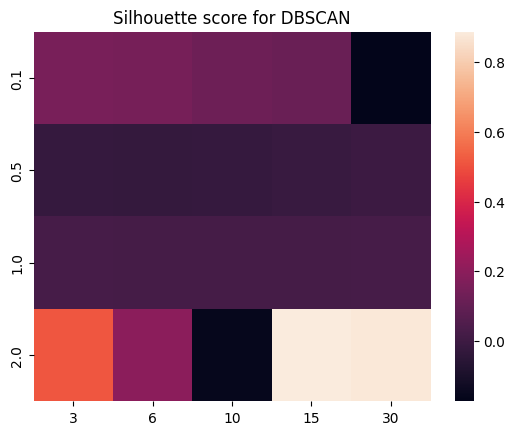

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots()
_ = ax.set_xlabel("min_samples")
_ = ax.set_ylabel("epsilon")
_ = ax.set_title('Silhouette score for DBSCAN')
_ = sns.heatmap(metrics.squeeze().unstack(fill_value=0), ax=ax)

Lets see how the silhouette coefficient varies with the number of clusters.

In [ ]:
#hide
# compute silhouette scores for each dataframe in the data dictionary
data_clusters = {}

for ep, min_sample in tqdm.tqdm(list(itertools.product(eps, min_samples))):
    data_clusters[(ep, min_sample)] = data[(ep, min_sample)]["label"].nunique() - 1

100%|██████████| 20/20 [00:00<00:00, 1974.07it/s]


In [ ]:
#hide
# merge metrics dataframe and data_clusters dictionary
metrics = pd.concat([metrics, pd.Series(data_clusters).to_frame()], axis=1)
metrics.columns = ["silhouette_score", "clusters"]
metrics.index.name = ("epsilon", "min_samples")

In [ ]:
metrics

silhouette_score  clusters
0.1 3           0.154212       510
    6           0.148491       113
    10          0.124754        29
    15          0.115893        15
    30         -0.172473         6
0.5 3          -0.021375        79
    6          -0.025580        20
    10         -0.021003         9
    15         -0.015158         8
    30         -0.003037         6
1.0 3           0.023871        34
    6           0.019254        14
    10          0.021831         7
    15          0.021976         9
    30          0.022781         9
2.0 3           0.510998        14
    6           0.199564         5
    10         -0.158038         2
    15          0.886707         1
    30          0.878244         1

From the model metric, `silhouette_score`, we can see that the silhouette coefficient is higher when the number of clusters is `1` for `eps` setting at 2. The coefficient reduces as the number of clusters increases.

**Based on the model metrics, we can select  `min_samples` is at `3` and the `eps` is at `2` for DBSCAN.**

> Note: Even though the silhouette coefficient is higher for the `eps` at 2 and `min_samples` at [15, 30], the number of clusters is only `1`, which doesnt provide information into the KVI's that are present in the data.

### Business metric

The business metric is based on the number of KVI's in the clusters out of the total observations in the cluster

In [ ]:
#hide
df_kvis = pd.read_parquet("data/raw/kvis.parquet")

Some of the KVI's available are

In [ ]:
df_kvis.head()

,PRODUCT_ID,PRODUCT_NAME,KVI
0,3986421,Microwaveable Beef Stew,False
1,5772734,Alka-Seltzer Plus Maximum Strength Cold & Flu ...,False
2,3980192,"Sail Cooked Shrimp, Frozen",False
3,4047775,Conventional Oil 10W,False
4,4300863,Meijer Omega 3 Krill Oil,False


In [ ]:
df_kvis.shape
df_kvis['KVI'].value_counts()
df_kvis['KVI'].mean()

(49788, 3)

False    48131
True      1604
Name: KVI, dtype: int64

0.0322509299286217

> Note: There are 1604 KVI's available which is 3.2% of the total number of products

In [ ]:
#hide
def compute_kvi_score(df, ep, min_sample):
    """
    Compute KVI score for a given dataframe
    """
    # merge kvis dataframe and temp_df dataframe
    temp_df = df.copy().reset_index()
    temp_df = pd.merge(temp_df, df_kvis, on="PRODUCT_ID", how="left")
    
    # get cluster and anomalies data
    temp_df_cls = temp_df[temp_df["label"] != -1]
    temp_df_anm = temp_df[temp_df["label"] == -1]
    
    # get percentage of kvis products in each label
    k = temp_df.groupby("label")['KVI'].mean()
    kvi_min = k.min()
    kvi_max = k.max()
    kvi_values = k.to_dict()
    
    # get the mean values for clusters and anomalies
    kvi_cluster_mean = temp_df_cls.groupby("label")['KVI'].mean().mean()
    kvi_anomaly_mean = temp_df_anm.groupby("label")['KVI'].mean().mean()
    
    return kvi_cluster_mean, kvi_anomaly_mean, kvi_min, kvi_max, kvi_values

In [ ]:
#hide
kvi_values = {}
kvi_min = {}
kvi_max = {}
kvi_cluster_mean = {}
kvi_anomaly_mean = {}

for ep, min_sample in tqdm.tqdm(list(itertools.product(eps, min_samples))):
    
    kvi_cluster_mean[(ep, min_sample)], kvi_anomaly_mean[(ep, min_sample)], kvi_min[(ep, min_sample)], kvi_max[(ep, min_sample)], kvi_values[(ep, min_sample)] = compute_kvi_score(data[(ep, min_sample)], ep, min_sample)

100%|██████████| 20/20 [00:01<00:00, 17.71it/s]


In [ ]:
#hide
def append_kvis_to_metrics(metrics, kvi_values, kvi_min, kvi_max, kvi_cluster_mean, kvi_anomaly_mean):
    """
    Append KVI scores to metrics dataframe
    """
    metrics = pd.concat([metrics, pd.Series(kvi_values).to_frame()], axis=1)
    metrics = pd.concat([metrics, pd.Series(kvi_min).to_frame()], axis=1)
    metrics = pd.concat([metrics, pd.Series(kvi_max).to_frame()], axis=1)
    metrics = pd.concat([metrics, pd.Series(kvi_cluster_mean).to_frame()], axis=1)
    metrics = pd.concat([metrics, pd.Series(kvi_anomaly_mean).to_frame()], axis=1)
    
    metrics.columns = ['silhouette_score', 'clusters', 'kvi_values', 'kvi_min', 'kvi_max', 'kvi_cluster_mean', 'kvi_anomaly_mean']
    
    metrics.dropna(axis=1, inplace=True)
        
    return metrics

Lets see how the business metric varies with the number of clusters, epsilon and min_samples.

In [ ]:
metrics = append_kvis_to_metrics(metrics, kvi_values, kvi_min, kvi_max, kvi_cluster_mean, kvi_anomaly_mean)
metrics

silhouette_score  clusters  \
0.1 3           0.154212       510   
    6           0.148491       113   
    10          0.124754        29   
    15          0.115893        15   
    30         -0.172473         6   
0.5 3          -0.021375        79   
    6          -0.025580        20   
    10         -0.021003         9   
    15         -0.015158         8   
    30         -0.003037         6   
1.0 3           0.023871        34   
    6           0.019254        14   
    10          0.021831         7   
    15          0.021976         9   
    30          0.022781         9   
2.0 3           0.510998        14   
    6           0.199564         5   
    10         -0.158038         2   
    15          0.886707         1   
    30          0.878244         1   

                                               kvi_values   kvi_min   kvi_max  \
0.1 3   {-1: 0.04879454423206224, 0: 0.0, 1: 0.0, 2: 0...  0.000000  0.333333   
    6   {-1: 0.044643371135801045, 0: 0.0, 1: 0.005675...  0.000000  0.058824   
    10  {-1: 0.04175835972304224, 0: 0.0, 1: 0.0062272...  0.000000  0.058824   
    15  {-1: 0.04033565857551031, 0: 0.0, 1: 0.0060899...  0.000000  0.071429   
    30  {-1: 0.0386177378954792, 0: 0.0048284625158831...  0.000000  0.055556   
0.5 3   {-1: 0.2274035693724813, 0: 0.0, 1: 0.02083556...  0.000000  1.000000   
    6   {-1: 0.2030754210397852, 0: 0.0, 1: 0.02037940...  0.000000  0.400000   
    10  {-1: 0.1868227134807109, 0: 0.0, 1: 0.01990458...  0.000000  0.186823   
    15  {-1: 0.1759682224428997, 0: 0.0, 1: 0.01946863...  0.000000  0.175968   
    30  {-1: 0.15584848990488903, 0: 0.0, 1: 0.0186312...  0.000000  0.155848   
1.0 3   {-1: 0.35478408128704486, 0: 0.0, 1: 0.1033894...  0.000000  1.000000   
    6   {-1: 0.3374012921751615, 0: 0.0, 1: 0.01863124...  0.000000  1.000000   
    10  {-1: 0.3197969543147208, 0: 0.0, 1: 0.01863124...  0.000000  0.319797   
    15  {-1: 0.30525100980957875, 0: 0.0, 1: 0.0186312...  0.000000  0.347826   
    30  {-1: 0.2682163611980331, 0: 0.0, 1: 0.01863124...  0.000000  0.268216   
2.0 3   {-1: 0.47815533980582525, 0: 0.031128404669260...  0.000000  1.000000   
    6   {-1: 0.48975409836065575, 0: 0.030644222590320...  0.000000  0.489754   
    10  {-1: 0.46904315196998125, 0: 0.030395272841219...  0.030395  0.469043   
    15  {-1: 0.46283783783783783, 0: 0.029918262232672...  0.029918  0.462838   
    30  {-1: 0.4330042313117066, 0: 0.029255916296196505}  0.029256  0.433004   

        kvi_cluster_mean  kvi_anomaly_mean  
0.1 3           0.007180          0.048795  
    6           0.000776          0.044643  
    10          0.003214          0.041758  
    15          0.011052          0.040336  
    30          0.016016          0.038618  
0.5 3           0.058924          0.227404  
    6           0.038522          0.203075  
    10          0.012889          0.186823  
    15          0.014446          0.175968  
    30          0.013169          0.155848  
1.0 3           0.166219          0.354784  
    6           0.143741          0.337401  
    10          0.025195          0.319797  
    15          0.057934          0.305251  
    30          0.026357          0.268216  
2.0 3           0.387144          0.478155  
    6           0.017240          0.489754  
    10          0.042975          0.469043  
    15          0.029918          0.462838  
    30          0.029256          0.433004

When epsilon is at 2 and 
 - When min_samples is at 3, `kvi_cluster_mean` is at `0.29` and `kvi_anomaly_mean` is at `0.47`
 - When min_samples is at 6, `kvi_cluster_mean` is at `0.14` and `kvi_anomaly_mean` is at `0.48`

Lets see what is happening at (eps, min_samples) of (2.0, 3)
- `product count`: Number of products in the associated label
- `kvi_mean`: if a product is KVI then the value is 1, else 0. So the mean is the average of the KVI's in the label
- `kvis_in_label`: Number of KVI's in the label
- `kvi_percentage`: Percentage of KVI's in the label out of all the KVI's available

In [ ]:
#hide
def get_all_metrics_for_hp(metrics, ep, min_sample):
    """
    Get all metrics for a given hyperparameter
    """
    all_metrics = data[(ep, min_sample)].label.value_counts().sort_index().to_frame()
    all_metrics['count'] = pd.Series(metrics.loc[(ep, min_sample), :]['kvi_values'], name='kvi_mean')
    
    all_metrics.columns = ['product count', 'kvi_mean']
    all_metrics.index.name = 'label'
    
    all_metrics['kvis_in_label'] = (all_metrics['product count'] * all_metrics['kvi_mean']).astype(int)
    all_metrics['kvi_percentage'] = (all_metrics['kvis_in_label'] / df_kvis['KVI'].sum() * 100).round(2)
    
    return all_metrics

In [ ]:
ep = 2.0
min_sample = 3

In [ ]:
all_metrics = get_all_metrics_for_hp(metrics, ep, min_sample)
all_metrics.round(2)

,product count,kvi_mean,kvis_in_label,kvi_percentage
label,,,,
-1,410,0.48,196,12.22
0,44680,0.03,1390,86.66
1,3,0.00,0,0.00
2,35,0.00,0,0.00
3,4,1.00,4,0.25
4,36,0.06,2,0.12
5,5,0.67,3,0.19
6,3,1.00,3,0.19
7,3,1.00,3,0.19


In [ ]:
#hide
# for model_cards.md in nbs/models folder
print(all_metrics.round(2).to_markdown())

|   label |   product count |   kvi_mean |   kvis_in_label |   kvi_percentage |
|--------:|----------------:|-----------:|----------------:|-----------------:|
|      -1 |             410 |       0.48 |             196 |            12.22 |
|       0 |           44680 |       0.03 |            1390 |            86.66 |
|       1 |               3 |       0    |               0 |             0    |
|       2 |              35 |       0    |               0 |             0    |
|       3 |               4 |       1    |               4 |             0.25 |
|       4 |              36 |       0.06 |               2 |             0.12 |
|       5 |               5 |       0.67 |               3 |             0.19 |
|       6 |               3 |       1    |               3 |             0.19 |
|       7 |               3 |       1    |               3 |             0.19 |
|       8 |               3 |       0    |               0 |             0    |
|       9 |              11 |       0   

> Note: Half of the outliers (`label -1`) when epsilon is at `2` and min_samples is  `3` are KVI's. And the outlier KVI's correspond to `~12%` of the total number of KVI's.

The biggest cluster (`label 0`) has around `1390` KVI's which is ~`86%` of the total KVI's. However, the `KVI's` occupy only small portion of total products in that cluster. So, `cluster 0` is not as interesting as the anomalies and other clusters that have higher coverage and lower product count in the cluster

There are few cluster with `kvi_mean` at `1`. These small clusters, even though has limited products, can be used to identify the KVI's in the data. Some of the interesting small clusters are `label 3`, `label 6`, `label 7` and `label 11`

In [ ]:
ep = 2.0
min_sample = 6

In [ ]:
all_metrics = get_all_metrics_for_hp(metrics, ep, min_sample)
all_metrics.round(2)

,product count,kvi_mean,kvis_in_label,kvi_percentage
label,,,,
-1,485,0.49,237,14.78
0,44636,0.03,1367,85.22
1,35,0.00,0,0.00
2,36,0.06,2,0.12
3,9,0.00,0,0.00
4,5,0.00,0,0.00


In [ ]:
#hide
# for model_cards.md in nbs/models folder
print(all_metrics.round(2).to_markdown())

|   label |   product count |   kvi_mean |   kvis_in_label |   kvi_percentage |
|--------:|----------------:|-----------:|----------------:|-----------------:|
|      -1 |             485 |       0.49 |             237 |            14.78 |
|       0 |           44636 |       0.03 |            1367 |            85.22 |
|       1 |              35 |       0    |               0 |             0    |
|       2 |              36 |       0.06 |               2 |             0.12 |
|       3 |               9 |       0    |               0 |             0    |
|       4 |               5 |       0    |               0 |             0    |


> Note: Half of the outliers (`label -1`) when epsilon is at `2` and min_samples is `6` are KVI's. And the outlier KVI's correspond to `~15%` of the total number of KVI's.

The biggest cluster (`label 0`) has around `1367` KVI's which is ~`85%` of the total KVI's. However, the `KVI's` occupy only small portion of total products in that cluster

## Parameters to chose for the model

**Based on the model and business metrics, we can select  `min_samples` is at `6` and the `eps` is at `2` for DBSCAN for this dataset**

## What are the outlier KVI's?

In [ ]:
ep = 2.0
min_sample = 3

In [ ]:
#hide
temp_df = data[(ep, min_sample)].copy().reset_index()
temp_df = pd.merge(temp_df, df_kvis, on="PRODUCT_ID", how="left")

In [ ]:
#hide
temp_df.query("label == -1 and KVI == 1")['PRODUCT_NAME'].to_list()

['2% Reduced Fat Milk',
 '36% Heavy Whipping Cream Ultra Pasteurized',
 'All Natural Chicken Nuggets',
 'All Natural Chicken Nuggets',
 'All Natural Crispy Chicken Strips',
 'Artesano Style Bread',
 'Avocado',
 'BASIC PAPER TOWELS SAS WHITE 6 BIG ROLLS',
 'Baby Cut Carrots, Bag',
 'Bacon',
 'Bagged Ice',
 'Banana',
 'Bartlett Pear',
 'Boneless, Skinless Chicken Breast',
 'Bottle',
 'Brand 100% Natural Spring Water Bottles',
 'Bread Split Top Wheat',
 'Bread Split Top White',
 'Broccoli, Bunch',
 'Brownberry Bread Italian',
 'Brussel Sprouts, Bagged',
 'Bun Size Beef Franks',
 'Buttermilk Bread',
 'Cage Free Grade A Large Egg 2 doz',
 'Cage Free Grade A Large Egg Dozen',
 'Cantaloupe',
 'Center Cut Original Bacon',
 'Certified Angus Beef 80/20 Ground Chuck',
 'Certified Angus Beef 90/10 Ground Sirloin',
 'Cherries',
 'Chicken Breast Tenderloins, Boneless & Skinless',
 'Chicken Breasts with Rib Meat, Family Pack, Boneless & Skinless',
 'Chicken Breasts, Boneless & Skinless',
 'Chicken Dr

```python
['2% Reduced Fat Milk',
 '36% Heavy Whipping Cream Ultra Pasteurized',
 'All Natural Chicken Nuggets',
 'All Natural Chicken Nuggets',
 'All Natural Crispy Chicken Strips',
 'Artesano Style Bread',
 'Avocado',
 'BASIC PAPER TOWELS SAS WHITE 6 BIG ROLLS',
 'Baby Cut Carrots, Bag',
 'Bacon',
 'Bagged Ice',
 'Banana',
 'Bartlett Pear',
 'Boneless, Skinless Chicken Breast',
 'Bottle',
 'Brand 100% Natural Spring Water Bottles',
 'Bread Split Top Wheat',
 'Bread Split Top White',
 'Broccoli, Bunch',
 'Brownberry Bread Italian',
 'Brussel Sprouts, Bagged',
 'Bun Size Beef Franks',
 'Buttermilk Bread',
 'Cage Free Grade A Large Egg 2 doz',
 'Cage Free Grade A Large Egg Dozen',
 'Cantaloupe',
 'Center Cut Original Bacon',
 'Certified Angus Beef 80/20 Ground Chuck',
 'Certified Angus Beef 90/10 Ground Sirloin',
 'Cherries',
 'Chicken Breast Tenderloins, Boneless & Skinless',
 'Chicken Breasts with Rib Meat, Family Pack, Boneless & Skinless',
 'Chicken Breasts, Boneless & Skinless',
 'Chicken Drumsticks Family Pack',
 'Chicken Thighs Family Pack, Bone-In, Skin-On',
 'Chicken Thighs Family Pack, Boneless & Skinless',
 'Chicken Wings Family Pack',
 'Chopped Caesar Salad Kit, Bag',
 'Cinnamon Rolls With Icing',
 'Classic Potato Chips',
 'Coca-Cola',
 'Coffeemate Natural Bliss Vanilla Almond Milk Liquid Coffee Creamer',
 'Cola Soda',
 'Colby Jack Cheese',
 'Condensed Chicken Noodle Soup',
 'Condensed Cream of Chicken Soup',
 'Condensed Cream of Mushroom Soup',
 'Corn',
 'Corn Whole Kernel Golden Sweet',
 'Creamy Peanut Butter',
 'Cucumber',
 'Dearborn Spiral Sliced Glazed Ham',
 'Dearborn Spiral Sliced Glazed Ham',
 'Diet Coke',
 'Diet Coke Bottles',
 'Diet Coke Soda',
 'Diet Mountain Dew Citrus Soda Bottles',
 'Diet Pepsiplastic bottles',
 'Distilled Water',
 'Everything Bagels',
 'Farmhouse Hearty White Bread',
 'Fat Free Milk',
 'Finely Shredded Mexican Cheese',
 'Fresh Ground Beef, 80% Lean',
 'Frozen Turkey Hen',
 'Gala Apple',
 'Gluten Free Chicken Nuggets',
 'Goldfish Cheddar',
 'Goldfish Cheddar Baked Snack Crackers',
 'Granny Smith Apple',
 'Green Asparagus',
 'Green Beans Cut Blue Lake',
 'Green Bell Pepper',
 'Green Cabbage',
 'Green Onion, Bunch',
 'Green Seedless Grapes, Bag',
 'Greenhouse Tomato',
 'Ground Beef, 80% Lean',
 'Ground Beef, 90% Lean',
 'Ground Beef, 96% Lean',
 'Half & Half',
 'Hamburger Buns',
 'Hearts of Romaine, Bag',
 'Hearty Thick Cut Bacon',
 'Honey Roasted Turkey Breast',
 'Honey Wheat Bread',
 'Honeycrisp Apple',
 'Honeysuckle White All-Natural Frozen Whole Turkey Tom',
 'Hot Dog Enriched Buns',
 'Iceberg Lettuce',
 'Jalapeno Pepper',
 'Jennie-O Lean Ground Turkey',
 'Jennie-O Turkey Store Lean Ground Turkey, 93% Lean',
 'Juice Original',
 'Katie’s Best Thin Sliced Chicken Breast',
 'Krakus Polish Ham with Natural Juices',
 'Large Garlic',
 'Large Meijer Seedless Watermelon Chunks, Cut & Ready to Eat, Bowl',
 'Large Navel Orange',
 'Lemon',
 'Light Beer',
 'Light Brown Sugar',
 'Lime',
 'Little Bites Chocolate Chip Muffins',
 'Lunchables Pepperoni Pizza',
 'Lunchables Turkey & American Cracker Stackers',
 'Macaroni & Cheese Dinner Original',
 'Mango',
 'Medium Soft Taco Flour Tortillas',
 'Meijer 8-5/8" Paper Plates',
 'Meijer Fresh Heavy Whipping Cream',
 'Meijer Frozen Turkey',
 'Meijer Ham, Boneless, Hickory Smoked, Fully Cooked, Whole',
 'Meijer Ham, Boneless, Hickory Smoked, Fully Cooked, Whole',
 'Melon Watermelon Seedless',
 'Milk 1% Lowfat, Gallon',
 'Milk 2% Reduced Fat',
 'Milk 2% Reduced Fat, Gallon',
 'Milk Vitamin D, Gallon',
 'Natural Sliced Colby Jack Cheese',
 'Natural Sliced Provolone Cheese',
 'Nestle Pure Life Purified Water',
 'Novara Hard Salami',
 'Orange Bell Pepper',
 'Organic 2% Reduced Fat Milk',
 'Organic Bananas, Bunch',
 'Organic Cage Free Extra Large Eggs',
 'Organic Extra Large Brown Eggs',
 'Organic Vitamin D Milk',
 'Original Baked Snack Crackers',
 'Original Crackers',
 'Original Crescent Rolls',
 'Original Mashed Potatoes',
 'Original Strawberry Yogurt',
 'Oven Roasted Turkey Breast',
 'Penny Smart Grade A Large Egg Dozen',
 'Peppermint Mocha Coffee Creamer',
 'Philadelphia Original Cream Cheese',
 'Philadelphia Original Cream CheeseEach',
 'Plain Bar Cream Cheese',
 'Plain Pre-Sliced Bagels',
 'Premium Original Saltine Crackers',
 'Premium Pure Cane Granulated Sugar',
 'Pure & Natural Sour Cream',
 'Pure Premium No Pulp Pure 100% Florida Orange Juice',
 'Pure Unflavored Water',
 'Purified Water Bottles',
 'Red Bell Pepper',
 'Red Onion',
 'Red Seedless Grapes, Bag',
 'Reddi Wip Original Whipped Cream',
 'Roma Tomato',
 'Russet Potato',
 'Russet Potatoes, Bag',
 'Salted Butter Quarters',
 'Salted Butter Sticks',
 'Shredded Hash Browns',
 'Shredded Lettuce, Bag',
 'Shredded Mozzarella Cheese',
 'Shredded Sharp Cheddar Cheese',
 'Simply 100 Oj/Pulp Free',
 'Simply Orange Juice with Calcium',
 'Simply Tomato Ketchup',
 'Singles American Cheese Slices',
 'Sld Spinach Baby Clm 5Oz Og',
 'Sliced Smoked Bacon',
 'Sliced Smoked Bacon',
 'Smithfield Spirals Flavored Sliced Smoked Ham with Natural Juices, Naturally Smoked Hickory',
 'Soda',
 'Soda Bottles',
 'Soda Bottles',
 'Spring Water',
 'Spring Water',
 'Steamfresh Premium Selects Frozen Broccoli Florets',
 'Strawberries',
 'Sugar Snap Peas, Bag',
 'Sweet Grape Tomatoes, pint',
 'Sweet Onion',
 'Sweet Potato',
 'Sweet Rolls',
 'Taco Seasoning Mix Original',
 'Thick Cut Bacon',
 'Thin Sliced Chicken Breasts Family Pack, Boneless & Skinless',
 'Tomatoes On The Vine (4-5 Tomatoes)',
 'Traditional Feta Cheese',
 'True Goodness Organic Sliced White Mushrooms',
 'Ultimate Caesar Salad Kit, Bag',
 'Unsalted Butter Quarters',
 'Vitamin D Milk',
 'White Bread',
 'White Onion',
 'Whole Rotisserie Chicken',
 'Whole Turkey Tom',
 'Whole Young Chicken',
 'Yellow Squash',
 'Zero Soda',
 'Zucchini Squash']
```

## Next steps

### Feature importance

The feature importance method for cluster and anomaly is still under development. 

The feature importance method should be treated differently for cluster and anomaly. For anomaly, we are only looking at single observation, while for cluster, we are looking at the entire cluster.


Once the feature importance method is ready, we will be able to use it to select the important features for each cluster and anomaly which can help in understanding the factors that are contributing to the KVI's in the provided data

### How anomalous the observations are?

With the help of clustering alogorithm, we are able to identify anomalies which correspond to KVI's. However, not all anomalies are KVI's. So, we need to find out which anomalies are KVI's. To do this, we will use the anomaly score and rank the anomalies based on the anomaly score.

If the anomalies with higher score correspond to KVI's, then we can set the threshold to the score and identify the KVI's

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_data.ipynb.
Converted 01_analysis.ipynb.
Converted 02_models.ipynb.
Converted 03_feature_importance.ipynb.
Converted 04_validation.ipynb.
Converted index.ipynb.
